# Assignment 3

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).
---

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
from sklearn.model_selection import train_test_split
import tensorflow as tf
from matplotlib import pyplot as plt

This lab continues our study of linear regression. You'll train your first models with Tensorflow, using a real dataset to predict car prices from their features. Note that Tensorflow is a rapidly changing library. This means you'll often see warnings about deprecations. You can ignore the warnings in our labs.

---
### Step 1: Data ingestion

You'll use the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile)  from 1985 Ward's Automotive Yearbook that is part of the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets).

In [3]:
# Provide the names for the feature columns since the CSV file with the data 
# does not have a header row.
cols = ['symboling', 'losses', 'make', 'fuel-type', 'aspiration', 'num-doors',
        'body-style', 'drive-wheels', 'engine-location', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-type', 'num-cylinders',
        'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio',
        'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

# Load the data from a CSV file into a pandas dataframe. Remember that each row
# is an example and each column in a feature.
car_data_init = pd.read_csv(
    'https://storage.googleapis.com/ml_universities/cars_dataset/cars_data.csv',
    sep=',', names=cols, header=None, encoding='latin-1')

# Display top five rows
print('Shape of data:', car_data_init.shape)
car_data_init.head()

Shape of data: (205, 26)


,symboling,losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


---
### Step 2: Data preprocessing

This step is essential for preparing the data in a format that is suitable for ML algorithms. It helps ensure data quality and improvements in model performance.

### <span style="color:chocolate">Exercise 1:</span> Column selection (5 points)

To keep things simple, you will:

1. Retain only the following columns: ['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']. Name the new dataframe *car_data*.
2. Display the data type of each column;
3. Convert the data type of each columns to numeric. Coerce missing values to NaN. Hint: use <span style="color:chocolate">pd.to_numeric()</span> method;
4. Display the data type of each column after the transformation performed at point 3.

In [59]:
# YOUR CODE HERE

#keeping the desired columns in the new dataframe 
car_data = car_data_init.loc[:,['horsepower', 'peak-rpm','city-mpg','highway-mpg','price']]
print(car_data.head())

#printing data type of each column
print(car_data.dtypes)

car_data = car_data.apply(pd.to_numeric, errors='coerce')
print(car_data.dtypes)
print(car_data.shape)


  horsepower peak-rpm  city-mpg  highway-mpg  price
0        111     5000        21           27  13495
1        111     5000        21           27  16500
2        154     5000        19           26  16500
3        102     5500        24           30  13950
4        115     5500        18           22  17450
horsepower     object
peak-rpm       object
city-mpg        int64
highway-mpg     int64
price          object
dtype: object
horsepower     float64
peak-rpm       float64
city-mpg         int64
highway-mpg      int64
price          float64
dtype: object
(205, 5)


### <span style="color:chocolate">Exercise 2:</span> Example (row) selection (5 points)

To keep things simple again, you will:

1. Print the shape of the car_data;

2. Remove examples (rows) that have missing value(s). Note that in doing so, you will overwrite the car_data dataset. You should end up with 199 examples after this cleaning.

3. Print the shape of the car_data again.

It's important to acknowledge that there are multiple approaches to handling missing features, and simply discarding examples with any missing feature, though straightforward, may not be the most optimal solution. However, for the sake of simplicity, you will implement this strategy in this assignment.

In [60]:
# YOUR CODE HERE
print(car_data.shape)

car_data = car_data.dropna()

print("Shape after dropping rows with missing values:", car_data.shape)



(205, 5)
Shape after dropping rows with missing values: (199, 5)


### <span style="color:chocolate">Exercise 3:</span> Data shuffling (10 points)

Since you'll be using Batch Gradient Descent (BGD) for training, it is important that **each batch is a random sample of the data** so that the gradient computed is representative. Note that the original data (above) appears sorted by *make* in alphabetic order.

Using NumPy and Pandas methods:

1. Create a list of indices corresponding to the rows in the car_data dataset. Call this list *indices*. Print this list;

2. Shuffle *indices* using the <span style="color:chocolate">np.random.permutation()</span> method. Call the resulting array *shuffled_indices*. Print this array;
    
3. Use the method <span style="color:chocolate">dataframe.reindex()</span> to change the ordering of the car_data dataset based on the order in the *shuffled_indices* array. Note that in doing so, you will overwrite the original dataset. Print the top 5 rows.

In [63]:
np.random.seed(0)
# YOUR CODE HERE

#Reset the index of the DataFrame
car_data.reset_index(drop=True, inplace=True)

#Creating a list of indices corresponding to each row without NaN values
indices = car_data.index.tolist()

#Printing the list of indices
print(indices)

shuffled_indices = np.random.permutation(indices)
print('shuffled indices:', shuffled_indices)

#changing the ordering of car_data based on the order in shuffled_indices
car_data = car_data.reindex(shuffled_indices)
print("Top 5 rows of the shuffled car_data DataFrame:", car_data.head())




[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198]
shuffled indices: [ 18 169 106  92 176 183   5 139  12 160  61 124 164 145  80   7  33 129
  37  74 159 144  45 15

### <span style="color:chocolate">Exercise 4:</span> Define outcome and features (5 points)

Create two dataframes as follows:

1. The first dataframe contains our outcome of interest: ['price']. Note, this is what we are aiming to predict. Name this dataframe Y. Print shape of Y.
2. The second dataframe contains our features of interest: ['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']. Name this dataframe X. Print shape of X.


In [73]:
# YOUR CODE HERE
Y =pd.DataFrame(car_data['price'])

print('shape of Y:', Y.shape)

X = pd.DataFrame(car_data[['horsepower', 'peak-rpm','city-mpg','highway-mpg']])
print('Shape of X:', X.shape)

shape of Y: (199, 1)
Shape of X: (199, 4)


### <span style="color:chocolate">Exercise 5:</span> Data splits (10 points)

Using the <span style="color:chocolate">train_test_split()</span> method available in scikit-learn:
1. Partition the (X, Y) data into training, validation, and test sets using a splitting rule of [60%, 20%, 20%], with a random state set to 1234. Name the resulting dataframes as follows: X_train, X_val, X_test, Y_train, Y_val, Y_test. Hint: To create these three partitions you will utilize the train_test_split() method twice. You should obtain [119, 40, 40] examples for training, validation, and test, respectively.
2. Print the shape of each dataframe.

Note: The validation set is crucial for evaluating different hyperparameter configurations and selecting those that yield optimal model performance. This approach avoids utilizing the test dataset during model training, as it is assumed to be "unknown" at that stage.

In [74]:
# YOUR CODE HERE

#splitting (X,Y) data into 60% training and 40% (validation + test) set. 
X_train, X_val_test, Y_train, Y_val_test = train_test_split(X, Y, test_size= 0.4, random_state=1234)

#splitting the (validation+test) set data into 50% validation and 50& test set which will give 20% of each from overall set. 

X_val, X_test, Y_val, Y_test = train_test_split(X_val_test, Y_val_test, test_size=0.5, random_state=1234)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_val shape:", Y_val.shape)
print("Y_test shape:", Y_test.shape)


X_train shape: (119, 4)
X_val shape: (40, 4)
X_test shape: (40, 4)
Y_train shape: (119, 1)
Y_val shape: (40, 1)
Y_test shape: (40, 1)


### <span style="color:chocolate">Exercise 6:</span> Data standardization (10 points)

With this concept in mind, complete the following tasks:

1. Output the quantile values (0.25, 0.5, 0.75, 0.95) for all features in the X_train dataset. Are these values uniformly scaled across features?

2. Standardize all features in X_train, X_val, and X_test. Label the resulting dataframes as X_train_std, X_val_std, and X_test_std, respectively. Hint: standardize the validation and test data using the mean and standard deviation computed from the training data. Why?

3. Similar to point 2. but now standardize the outcome variable. Label the resulting dataframes as Y_train_std, Y_val_std, and Y_test_std.

In [90]:
# YOUR CODE HERE
X_train_quantiles = X_train.quantile([0.25,0.5,0.75,0.95])

print(X_train_quantiles)

'''The values appear to be uniformly scaled across peak-rpm, high-mpg. The values appear to be uniformly scaled across 
horsepower until 0.75 quantile. It is also close to uniformly scaled for peak-rpm (the scaling increases between 0.75 
0.95 quantile, but it is reasonable)'''

from sklearn.preprocessing import StandardScaler

# Creating a StandardScaler instance
scaler = StandardScaler()

# Fitting the scaler on X_train and transform X_train, X_val, and X_test
X_train_std = scaler.fit_transform(X_train)
X_val_std = scaler.transform(X_val)
X_test_std = scaler.transform(X_test)

'''StandardScaler standardizes data using the approach of computing the mean and standard deviation
from the training data and then applying the same transformation to the validation and test data.
This approach of standardizing is important for consistency (when the features are standardized, 
it is transforming them to have a mean of 0 and a standard deviation of 1. 
If the mean and standard deviation  are computed separately for the training, validation, and test sets,
then it introduces inconsistency in the scaling process which can lead to unexpected results
and makes it difficult to compare model performance across different datasets. 
This approach is also needed to generalize well.'''


# Fit the scaler on Y_train and transform Y_train, Y_val, and Y_test
Y_train_std = scaler.fit_transform(Y_train.values.reshape(-1, 1)).flatten()
Y_val_std = scaler.transform(Y_val.values.reshape(-1, 1)).flatten()
Y_test_std = scaler.transform(Y_test.values.reshape(-1, 1)).flatten()



      horsepower  peak-rpm  city-mpg  highway-mpg
0.25        69.0    4800.0      19.0         25.0
0.50        92.0    5000.0      25.0         31.0
0.75       116.0    5500.0      31.0         37.0
0.95       182.2    5900.0      37.0         42.1


---
### Step 3: Exploratory data analysis (EDA)

EDA plays a very important role in ML. The goal here is to develop a good understanding of our dataset, identify any data quality issues, understand patterns and relationships, which in turn, aids in subsequent modeling and interpretations.

### <span style="color:chocolate">Exercise 7:</span> Scatterplot matrix (10 points)

In this exercise you will use some simple yet useful techniques to visualize the distribution of the data. 

Let's start with:

1. A scatterplot matrix to visualize the pair-wise correlations between different features and outcome in the (X_train_std, Y_train_std) data. You will use the <span style="color:chocolate">sns.pairplot()</span> method from the seaborn library imported at the top of the notebook;
2. Is any of the variables in the data normally distributed? Is it necessary for the explanatory or target variable to be normally distributed in order to train a ML model?

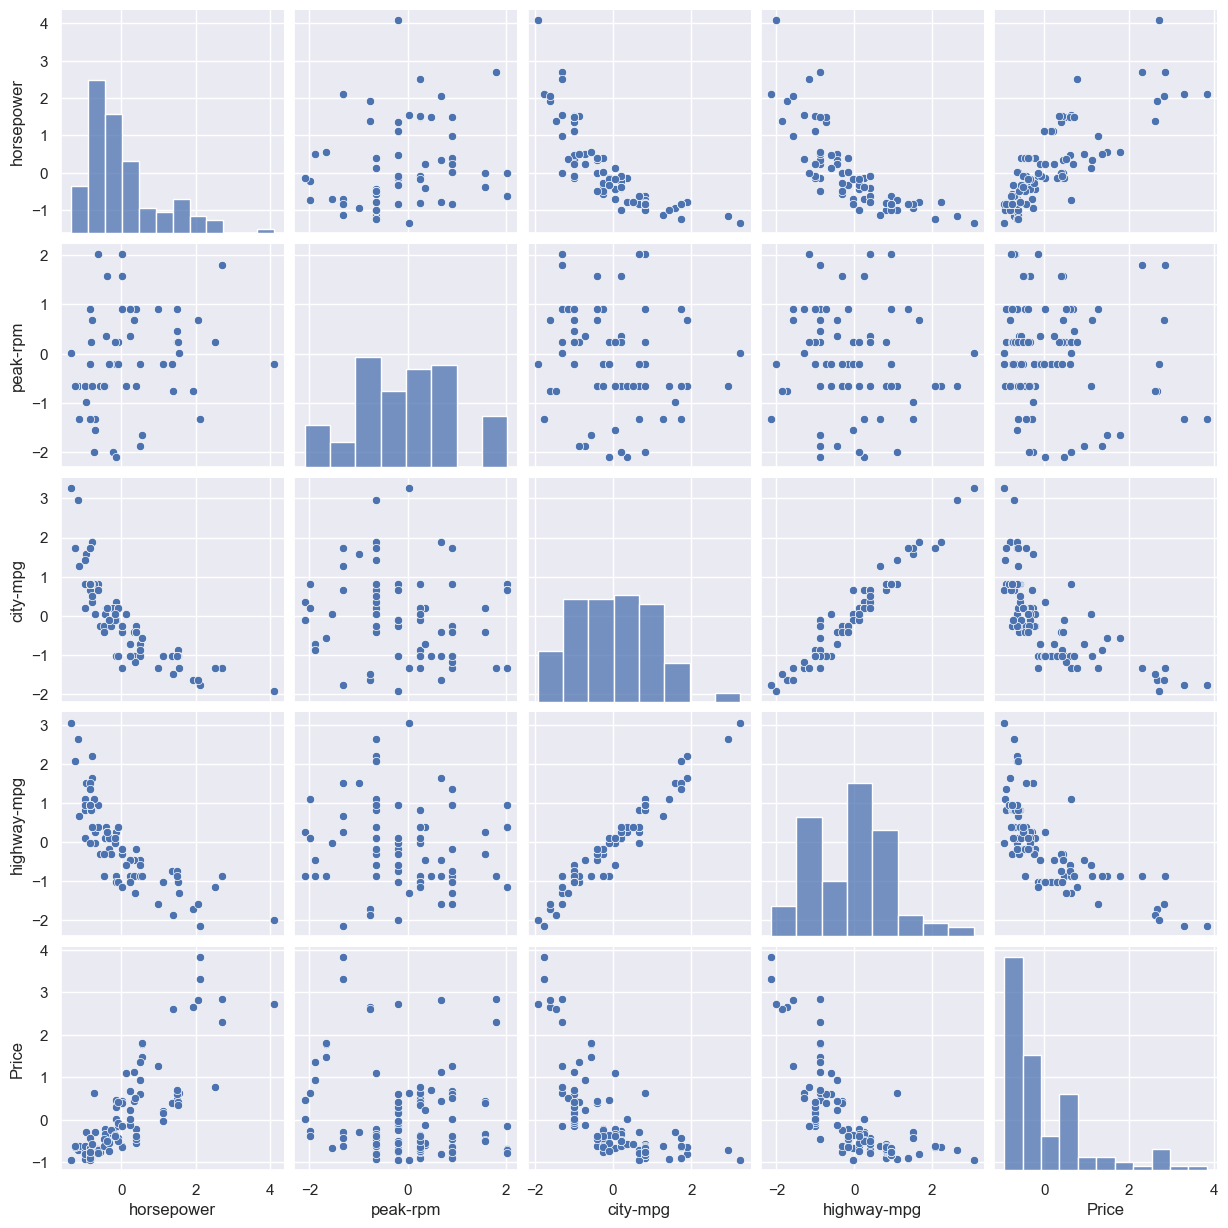

'Looking at the histogram, the data/features do not appear to be normally distributed. Only city-mpg appears to be\nnormally distributed. \nLinear regression assumes that the residuals (errors) are normally distributed, \nbut it is not a requirement for the explanatory or target variables themselves to be normally distributed,\nespecially with large sample sizes.'

In [84]:
# YOUR CODE HERE
# Combining X_train_std and Y_train_std into a single DataFrame for visualization
train_data_std = pd.concat([pd.DataFrame(X_train_std, columns=X.columns), pd.Series(Y_train_std, name='Price')], axis=1)

#Creating a scatterplot matrix
sns.pairplot(train_data_std)
plt.show()

'''Looking at the histogram, the data/features do not appear to be normally distributed. Only city-mpg appears to be
normally distributed. 
Linear regression assumes that the residuals (errors) are normally distributed, 
but it is not a requirement for the explanatory or target variables themselves to be normally distributed,
especially with large sample sizes.'''

### <span style="color:chocolate">Exercise 8:</span> Correlation matrix (10 points)

In this exercise you will:

1. Plot a correlation matrix in the form of a heatmap to visualize the linear relationships between different features and outcome in the (X_train_std, Y_train) data. Hint: this example here is very useful: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
    
2. Answer the following questions: 
 - Which two features are likely to be most redundant?
 - Which feature is likely to be least useful for predicting price?

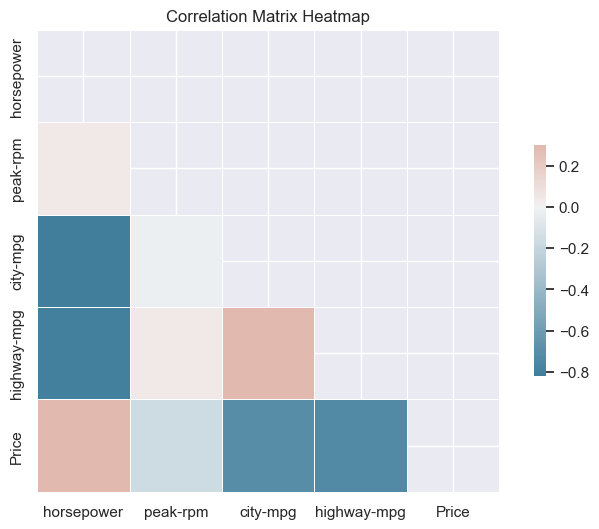

In [86]:
# YOUR CODE HERE
# Computing the correlation matrix from the combined X_train_std and Y_train_std DataFrame
corr = train_data_std.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix Heatmap')
plt.show()


'''1. city-mpg and highway-mpg are likely to be the most redundant features. 
2. peak-rpm is likely to be the least useful in predicting price as it 
has the least/lowest absolute correlation with price'''


---
### Step 4: Modeling

### <span style="color:chocolate">Exercise 9:</span> Baseline model (5 points)

Let's start by evaluating a baseline model. Precisely, you'll use the average price of cars in the training set as our baseline model -- that is, the baseline always predicts the average price regardless of the input.

1. Implement this baseline using the Y_train_std data and print the average price. Note: You can revert the price variable to the original scale for interpretation purposes.

In [91]:
# YOUR CODE HERE
#Calculating the average price in the training set
average_price_std = Y_train_std.mean()

#Revert the average price to the original scale
average_price = scaler.inverse_transform(np.array([average_price_std]).reshape(-1, 1))[0]

# Print the average price
print("Average price of cars in the training set:", average_price)


Average price of cars in the training set: [13139.92436975]


### <span style="color:chocolate">Exercise 10:</span> Improvement over Baseline with TensorFlow (10 points)

Let's train a linear regression model much like we did in the previous assignment, but this time using TensorFlow. 

1. Fill in the <span style="color:green">NotImplemented</span> parts of the build_model() function below by following the instructions provided as comments. Hint: refer to Demo 3 in [bCourses/Modules/Live Session Demos](https://bcourses.berkeley.edu/courses/1534588/files/88733489?module_item_id=17073646) for an example.
2. Build and compile a model using the build_model() function and the (X_train_std, Y_train_std) data. Set learning_rate = 0.0001. Call the resulting object *model_tf*.
3. Train *model_tf* using the (X_train_std, Y_train_std) data. Set num_epochs = 5. Pass the (X_val_std, Y_val_std) data for validation. Hint: see the documentation behind the [tf.keras.Model.fit()](https://bcourses.berkeley.edu/courses/1534588/files/88733489?module_item_id=17073646) method.
3. Generate a plot with the loss values on the y-axis and the epoch number on the x-axis for visualization. Make sure to include axes name and title. Hint: check what the [tf.keras.Model.fit()](https://bcourses.berkeley.edu/courses/1534588/files/88733489?module_item_id=17073646) method returns.

More notes on point 1: the idea is to build a *computational graph* for linear regression, and then send data through it. There are many ways to build graphs, but [TenforFlow Keras API](https://www.tensorflow.org/api_docs/python/tf/keras) is recommended. 

In [94]:
def build_model(num_features, learning_rate):
  """Build a TF linear regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # linear regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units= 1,        # output dim
      input_shape=(num_features,),  # input dim
      use_bias=True,               # use a bias (intercept) param
      kernel_initializer=tf.keras.initializers.Ones(),  # initialize params to 1
      bias_initializer=tf.keras.initializers.Ones(),    # initialize bias to 1
  ))

  # We need to choose an optimizer. We'll use GD, which is actually mini-batch GD
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Finally, compile the model. This finalizes the graph for training.
  #We specify the loss and the optimizer above
  model.compile(optimizer=optimizer, loss='mse')
    
  return model


Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 6.6868 - val_loss: 5.2879
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.6666 - val_loss: 5.2741
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.6465 - val_loss: 5.2604
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.6265 - val_loss: 5.2467
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.6066 - val_loss: 5.2331


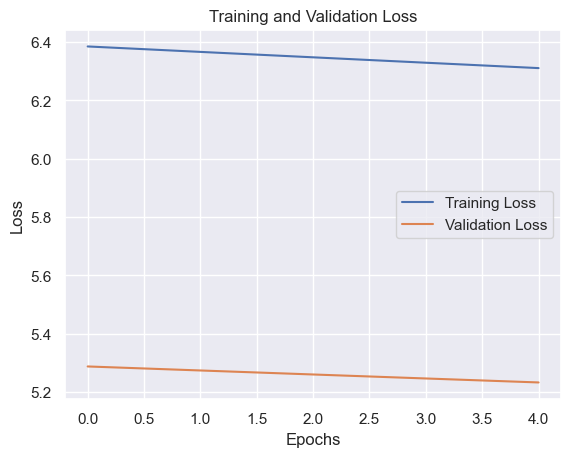

In [96]:
tf.random.set_seed(0)
# 2. Build and compile model
# YOUR CODE HERE
learning_rate = 0.0001
model_tf = build_model(num_features=X_train_std.shape[1], learning_rate=learning_rate)

# 3. Fit the model
# YOUR CODE HERE
num_epochs = 5
history = model_tf.fit(X_train_std, Y_train_std, epochs=num_epochs, validation_data=(X_val_std, Y_val_std), verbose=1)

# Plotting loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

---
### Step 5: Hyperparameter tuning

Hyperparameter tuning is a crucial step in optimizing ML models. It involves systematically adjusting hyperparameters such as learning rate, number of epochs, and optimizer to find the model configuration that leads to the best generalization performance.

This tuning process is typically conducted by monitoring the model's performance on the validation vs. training set. It's important to note that using the test set for hyperparameter tuning can compromise the integrity of the evaluation process by violating the assumption of "blindness" of the test data.

### <span style="color:chocolate">Exercise 11:</span> Hyperparameter tuning (10 points)

1. Fine-tune the hyperparameters of *model_tf* to determine the setup that yields the most optimal generalization performance. Feel free to explore various values for the hyperparameters. Hint: ask your instructors and TAs for help if in doubt.

After identifying your preferred model configuration, print the following information:

2. The learned parameters of the model (this should include the bias term). Hint: use  <span style="color:chocolate">model_tf.layers[0].get_weights()</span>.
3. The loss at the final epoch on both the training and validation datasets;
4. The percentage difference between the losses observed on the training and validation datasets.


Please note that we will consider 'optimal model configuration' any last-epoch loss that is below 0.35.

In [98]:
tf.random.set_seed(0)
# YOUR CODE HERE

# Hyperparameters
learning_rates = [0.001, 0.0001, 0.00001]
num_epochs = 10

# Lists to store results
final_train_losses = []
final_val_losses = []

# Defining function to build and compile the model with different hyperparameters
def build_and_compile_model(num_features, learning_rate):
    model = build_model(num_features=num_features, learning_rate=learning_rate)
    return model

# Iterating over learning rates
for lr in learning_rates:
    # Build and compile the model
    model_tf = build_and_compile_model(num_features=X_train_std.shape[1], learning_rate=lr)
    
    # Train the model
    history = model_tf.fit(X_train_std, Y_train_std, epochs=num_epochs, validation_data=(X_val_std, Y_val_std), verbose=0)
    
    #Calculating final losses
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    
    #Append to lists
    final_train_losses.append(final_train_loss)
    final_val_losses.append(final_val_loss)

# Finding the index of the minimum validation loss
best_lr_index = np.argmin(final_val_losses)
best_lr = learning_rates[best_lr_index]

# Print the best learning rate
print("Best learning rate:", best_lr)

# Build and compile the model with the best learning rate
best_model_tf = build_and_compile_model(num_features=X_train_std.shape[1], learning_rate=best_lr)

# Train the best model
history_best = best_model_tf.fit(X_train_std, Y_train_std, epochs=num_epochs, validation_data=(X_val_std, Y_val_std), verbose=0)

# Print the learned parameters of the model
learned_parameters = best_model_tf.layers[0].get_weights()
print("Learned parameters of the model (including bias term):", learned_parameters)

# Printing the loss at the final epoch on both the training and validation datasets
final_train_loss_best = history_best.history['loss'][-1]
final_val_loss_best = history_best.history['val_loss'][-1]
print("Loss at final epoch on training dataset:", final_train_loss_best)
print("Loss at final epoch on validation dataset:", final_val_loss_best)

#Calculating and print the percentage difference between the losses observed on the training and validation datasets
percentage_difference = ((final_train_loss_best - final_val_loss_best) / final_train_loss_best) * 100
print("Percentage difference between training and validation losses:", percentage_difference)


Best learning rate: 0.001
Learned parameters of the model (including bias term): [array([[1.1001021 ],
       [0.90568155],
       [0.86738014],
       [0.8575456 ]], dtype=float32), array([0.9218704], dtype=float32)]
Loss at final epoch on training dataset: 4.911504745483398
Loss at final epoch on validation dataset: 4.1347975730896
Percentage difference between training and validation losses: 15.814036891811126


---
### Step 6: Evaluation and Generalization


Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

### <span style="color:chocolate">Exercise 12:</span> Computing MSE (10 points)

1. Calculate MSE on both (X_train_std, Y_train_std) and (X_test_std, Y_test_std) datasets. Hint: You can utilize the <span style="color:chocolate">model.evaluate()</span> method provided by tf.keras.

2. Does the model demonstrate strong generalization capabilities? Provide an explanation based on your observations.

4. Generate a plot to visualize the accuracy of the predictions. Plot the actual (observed) Y_test values on the x-axis and the predicted Y_test values on the y-axis. Additionally, include a 45-degree line in the plot for reference. Ensure that the plot contains appropriate axis labels and a title. Provide commentary on the model's fit based on this visualization. Hint: You can utilize the <span style="color:chocolate">model.predict()</span> method available in tf.keras. 

MSE on training dataset: 6.372537612915039
MSE on test dataset: 4.343052864074707
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


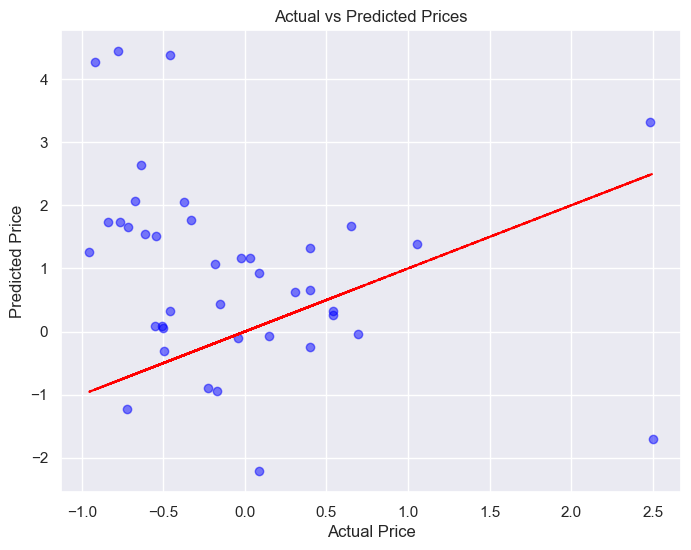

In [99]:
# YOUR CODE HERE
#Calculating MSE on training dataset
train_loss = model_tf.evaluate(X_train_std, Y_train_std, verbose=0)

#Calculating MSE on test dataset
test_loss = model_tf.evaluate(X_test_std, Y_test_std, verbose=0)

print("MSE on training dataset:", train_loss)
print("MSE on test dataset:", test_loss)

#Predicting on test dataset
Y_test_pred = model_tf.predict(X_test_std)

# Generate a plot to visualize the accuracy of the predictions
plt.figure(figsize=(8, 6))
plt.scatter(Y_test_std, Y_test_pred, color='blue', alpha=0.5)
plt.plot(Y_test_std, Y_test_std, color='red', linestyle='--')  # 45-degree line
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.grid(True)
plt.show()

'''The MSE on the test dataset is lower than the training dataset which shows that the model generalizes well. 
Except for a few points, most of the points are closer to the line in the plot which indicates the models
predictions are close to the actual value.
'''

----
### <span style="color:chocolate">Bonus question</span> (20 points)

In Exercise 12, you reported an aggregated MSE. Let's revisit the exercise by:

1. Conducting a subgroup model evaluation. More precisely, compute the test data MSE based on various car subgroups such as make, engine size, fuel type, etc.

2. Answering the question: is the model "fair" to your chosen car subgroups in our data?

In [ ]:
# YOUR CODE HERE